In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

from qutip import *
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$
$$
H_0 = \hbar  \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)}
+ \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{i j} \sigma_+^{(i)} \sigma_-^{(j)}
+ \hbar \omega_c a^{\dagger}a
$$

$$
H_I = \hbar  g(t) \Sigma_x (a^{\dagger} + a).
$$

$$
\displaystyle J_{i j} = \frac{\alpha}{|r_i-r_j|}.
$$

In [5]:
# Set the system parameters
n_rings = 1
n_chains = 1 # number of chains
N_atoms = n_chains * n_rings  # number of atoms

fixed_lam = 1.                # energysplitting of the atom, when ground state is set to 0
omega_a = 2 * np.pi / fixed_lam # actually k_a
omega_c = omega_a
distance = 1 * fixed_lam # defining topology                                    0.1 <--


g0 = 1 # coupling strength between cavity and atomic system

gamma_0 = .1   # decay rate of the atoms
gamma_phi = .0 # dephasing rate of the atoms

alpha = 1. # coupling strength of the dipoles       Fine structure const?

# evolution
t_max = 1
time_steps = 100
t_step_width = t_max / time_steps
times = np.linspace(0, t_max, time_steps) # list of times


def count_decimal_digits(number):
    # Convert the number to string
    str_number = str(number)

    # Split the string at the decimal point and count the digits after it
    if '.' in str_number:
        return len(str_number.split('.')[1])
    else:
        return 0  # No digits after decimal if it's an integer

tolerance = count_decimal_digits(times[1]) - 1
tol = 10**-tolerance

In [6]:
########################################               define the geometry                 #############################################
def chain_positions(distance, N_atoms):
    Pos = np.zeros((N_atoms, 3))
    for i in range(N_atoms):
        Pos[i, 2] = i * distance
    return Pos

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,            1]])

def ring_positions(distance, n_chains):
    Pos = np.zeros((n_chains, 3))
    dphi = 2 * np.pi / n_chains
    if n_chains == 1:
        radius = 0
    else:
        radius = distance / 2 / np.sin(np.pi / n_chains)
    helper = np.array([radius, 0, 0])
    for i in range(n_chains):
        rotation_matrix = z_rotation(dphi * i)
        Pos[i] = np.matmul(rotation_matrix, helper)
    return Pos

def cyl_positions(distance, N_atoms, n_chains):
    Pos = np.zeros((N_atoms, 3))
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    for i in range(n_chains):
        Pos[i * (N_atoms // n_chains): (i + 1) * (N_atoms // n_chains)] = Pos_chain + Pos_ring[i]
    return Pos

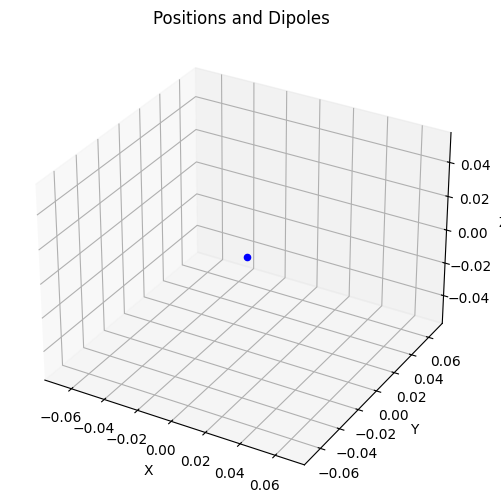

In [7]:
Pos = cyl_positions(distance, N_atoms, n_chains)

# Plotting 
fig = plt.figure(figsize=(8, 6)) 
ax = fig.add_subplot(111, projection='3d') 
# Plot the positions 
ax.scatter(Pos[:, 0], Pos[:, 1], Pos[:, 2], c='b', marker='o') 
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Positions and Dipoles')
ax.axis('equal')
plt.show()

In [8]:
# Define the ground & the excited states
# atomic dofs
atom_g = basis(N_atoms + 1, 0)
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]

# cavity dofs
cav_g = basis(2, 0)
cav_e = basis(2, 1)

# combined dofs
sm_list = []    # lowering operators of atomic system
S_x = 0         # collective sigma_x operator for the system

for i in range(N_atoms):
    op = atom_g * atom_es[i].dag()                       # tensor(qeye(2), atom_g * atom_es[i].dag()) # ID_2 x sigma_m_i
    sm_list.append(op)
    S_x += op + op.dag()

In [9]:
def Hamilton0(distance, n_rings, n_chains):
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = tensor([cav_g * cav_g.dag(), sm_list[a].dag() * sm_list[b]])
            if a != b:
                ra, rb = Pos[a, :], Pos[b, :]
                H += alpha / (np.linalg.norm(rb-ra)) * op
            else:
                H += omega_a * op # Diagonals except for |0><0|
    H += omega_c * tensor([cav_e * cav_e.dag(), atom_g*atom_g.dag()])
    return H
    
H0 = Hamilton0(distance, n_rings, n_chains)

H0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         6.28318531 0.         0.        ]
 [0.         0.         6.28318531 0.        ]
 [0.         0.         0.         0.        ]]

## Single case

$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

## Collective case
$$
C_{\text{decay}} = \sum_{n=1}^{N_{\text{atoms}}} C_{\text{decay}}^{(i)} \quad
C_{\text{dephase}} = \sum_{n=1}^{N_\text{atoms}} C_{\text{dephase}}^{(i)}
$$

In [10]:
# Jump / Expect Operators
# Define the decay collapse and dephasing operator for each spin

op_list = [tensor([qeye(2), sm]) for sm in sm_list]  # Operators combining the cavity (qeye(2)) and the atomic lowering operator (sm)

# Collapse operators
c_op2 = [np.sqrt(gamma_0) * op for op in op_list]                         # Individual atom decays
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in op_list] # Individual atom dephasing
c_op_list = c_op2 + c_op4  # Combine all collapse operators

# Expectation operators for measuring populations across atomic excited levels
e_op_list = [
    tensor(cav_g * cav_g.dag(), basis(N_atoms + 1, i) * basis(N_atoms + 1, i).dag())
    for i in range(N_atoms + 1)
]

In [11]:
# create the time dependant evolution

I = tensor([qeye(2), S_x]) * tensor([(create(2) + destroy(2)), qeye(N_atoms+1)]) # interaction Operator

E12 = 10 # Amplitude of laser pulses 1,2
E0s = [E12, E12, E12/10] # Probe pulse is smaller
omegas = [omega_a, omega_a, omega_a]
Delta_ts = [t_max/200, t_max/200, t_max/200] # narrow width of the pulses
t0s = [Delta_ts[0], Delta_ts[1], Delta_ts[2]]
phi12 = 2  * np.pi         # phis = [phi12, phi12, 0]  # Phase-kick?, pulse 1 and 2 are phase locked!

def heaviside(x):
    return 1 if x >= 0 else 0

def El_field(t, args):
    t0 = args['time']
    Delta = args['Delta']
    E = 1 / np.sqrt(2) * args['E0'] * heaviside(Delta - np.abs(t - t0)) * np.cos(np.pi*(t - t0)/(2*Delta))**2 * np.cos(args['omega'] * (t - t0) + args['phi'])
    return E

HI = [I, El_field] # interaction Hamiltonian with function-based time dependence
H = [H0, HI]

options = Options(store_states=True)

/home/leopold/PycharmProjects/Master_thesis/.venv/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [12]:
# evolution with t
# initial state
psiini = tensor([cav_e, basis(N_atoms+1, 0)]) # = |1>_gamma ø |g>_atom

#
# PREPROCESSING
#
# Define the phases, coherence times, and waiting times
phases = [i * np.pi/2 for i in range(4)]

# Initialize the main dictionary to hold the structure
data_dict = {}
data_dict_stage1 = {}
data_dict_stage2 = {}

# Loop through each phase φ
for phi in phases:
    # Create a subdictionary for each phase
    data_dict[phi] = {}
    data_dict_stage1[phi] = {}  # Stage 1 copy of the phase
    data_dict_stage2[phi] = {}  # Stage 2 copy of the phase

# Print the resulting nested dictionary structure
import pprint
pprint.pprint(data_dict)

{0.0: {}, 1.5707963267948966: {}, 3.141592653589793: {}, 4.71238898038469: {}}


In [13]:
# (first laser pulse)
times_0 = times

# Iterate over the phi values
for phi in data_dict_stage1:
    args_0 = {
        'phi': phi12,  # Use the phase from data_dict_stage1
        'time': Delta_ts[0],  # t0 value = Delta value such that the pulse immediatley starts
        'omega': omegas[0],  # omega value
        'Delta': Delta_ts[0], # The width should be
        'E0': E0s[0]  # E0 value
    }

    # Solve the system using mesolve (first laser pulse)
    result_0 = mesolve(H, psiini, times_0, c_ops=c_op_list, args=args_0, options=options)

    current_dict = {}

    for i in range(len(times_0)): # save only the states that make sense
        if (2 * (Delta_ts[0]) <= times_0[i] and times_0[i] <= t_max - 2 * (Delta_ts[1] + Delta_ts[2])):
            current_dict[i] = result_0.states[i]  # tau is indirectly stored in the index i (key of the dictionary)

    if current_dict:  # Check if the dictionary is not empty
        data_dict_stage1[phi] = current_dict

#pprint.pprint(data_dict_stage1)

In [14]:
# (second laser pulse)
# Iterate over the phi values
for phi, dic in data_dict_stage1.items():
    args_1 = {
        'phi': phi12,
        'time': Delta_ts[1],
        'omega': omegas[1],
        'Delta': Delta_ts[1],
        'E0': E0s[1]
    }

    # Iterate over the tau values and states after tau, from there make the second laser pulse
    for i, psiini_1 in dic.items():
        times_1 = times[i:]
        # Solve the system using mesolve (second laser pulse)
        result_1 = mesolve(H, psiini_1, times_1, c_ops=c_op_list, args=args_1, options=options)

        current_dict = {}
        for j in range(len(times_1)): # save only the states that make sense
            if (times[i] + 2 * (Delta_ts[1]) <= times_1[j] <= t_max - 2 * (Delta_ts[2])):
                current_dict[j] = result_1.states[j] # T is stored in the information j, together with i

        if current_dict:  # Check if the dictionary is not empty
            data_dict_stage2[phi][i] = current_dict

# After processing each coherence time, you can optionally print the current state of the dictionary
#pprint.pprint(data_dict_stage2)

In [15]:
# (third laser pulse)
data_dict = {}

# Iterate over the phi values
for phi, dic in data_dict_stage2.items():
    args_2 = {
        'phi': 0,       #last pulse has no phase kick
        'time': Delta_ts[2],  # Duration for the 2nd pulse
        'omega': omegas[2],  # Omega for the 2nd pulse
        'Delta': Delta_ts[2],  # Delta for the 2nd pulse
        'E0': E0s[2]  # E0 for the 2nd pulse
    }

    # Iterate over the tau values
    for i, dic1 in dic.items():
        coherence_time_i = times[i] - Delta_ts[0] + Delta_ts[1]
        tau = round(coherence_time_i, tolerance)  # Round  to tolearance decimal places carefull!
        times_1 = times[i:]

        # Iterate over the T values and make the last laser pulse
        for j, psiini_2 in dic1.items():

            times_2 = times[j:]
            # (last laser pulse)
            result_2 = mesolve(H, psiini_2, times_2, c_ops=c_op_list, args=args_2, options=options)

            waiting_time_j = times[j] - times[i] + Delta_ts[2] - Delta_ts[1]
            T = round(waiting_time_j, tolerance)

            # Iterate over the states in result_2 and store the ones that meet:
            # ONLY the first state with T >= times_2[0] + 2 Delta_ts[2] is important -> break
            for k in range(len(times_2)):
                if (times[i] + 2 * Delta_ts[1] <= times[j] and
                    times[j] + 2 * Delta_ts[2] <= times_2[k] <= t_max):
                    if phi not in data_dict:
                        data_dict[phi] = {}
                    if tau not in data_dict[phi]:
                        data_dict[phi][tau] = {}
                    if T not in data_dict[phi][tau]:
                        data_dict[phi][tau][T] = []

                    # store the final time and the final state
                    data_dict[phi][tau][T].append((round(times_2[k], tolerance), result_2.states[k]))

#                   break  # Stop after saving the first v pair

#pprint.pprint(data_dict)
# The final data_dict will now contain the results for each φ, τ, and T

In [16]:
# Create an empty dictionary `accumulated_data` to store lists of (\psi) for each ((\tau, T, t)):
accumulated_data = {}

for phi, phi_dict in data_dict.items():
    for tau, tau_dict in phi_dict.items():
        for T, T_list in tau_dict.items():
            for t, psi in T_list:

                # Create a key for the current combination
                key = (T, tau, t)
                # Add psi to the list for this combination
                if key not in accumulated_data:
                    accumulated_data[key] = []
                accumulated_data[key].append(psi)


# After accumulating all states (( \psi )) for each ((\tau, T, t)), compute the average and then also the expectation value
# <psi | S_x | psi>
averaged_data_dict = {}

for (T, tau, t), states in accumulated_data.items():
    # Compute the average of the states

    mean_psi = sum(states) / len(states)
    expect_val = expect(tensor([qeye(2), S_x]), mean_psi)

    # Save the result in averaged_data_dict
    if T not in averaged_data_dict:
        averaged_data_dict[T] = {}
    if tau not in averaged_data_dict[T]:
        averaged_data_dict[T][tau] = {}
    averaged_data_dict[T][tau][t] = expect_val

averaged_data_dict
# this is already in the order:
#     averaged_data_dict = {
#         T1: {
#             tau1: {t1: avg1, t2: avg2, ...},
#             tau2: {t1: avg1, t2: avg2, ...},
#             ...
#         },
#         T2: { ... }
#         ...
#     }
# here T1<T2<... and for each case tau1<tau2<... aswell as t1<t2<...
# for a fixed T: taui directly correponds to ti for which i runs from 0 to Steps = time_steps - T_steps = time_steps * (1 - T/t_max)

{np.float64(0.0101010101010101): {np.float64(0.0101010101010101): {np.float64(0.0303030303030303): 0.0,
   np.float64(0.0404040404040404): 0.0,
   np.float64(0.05050505050505051): 0.0,
   np.float64(0.06060606060606061): 0.0,
   np.float64(0.07070707070707072): 0.0,
   np.float64(0.08080808080808081): 0.0,
   np.float64(0.09090909090909093): 0.0,
   np.float64(0.10101010101010102): 0.0,
   np.float64(0.11111111111111112): 0.0,
   np.float64(0.12121212121212122): 0.0,
   np.float64(0.13131313131313133): 0.0,
   np.float64(0.14141414141414144): 0.0,
   np.float64(0.15151515151515152): 0.0,
   np.float64(0.16161616161616163): 0.0,
   np.float64(0.17171717171717174): 0.0,
   np.float64(0.18181818181818185): 0.0,
   np.float64(0.19191919191919193): 0.0,
   np.float64(0.20202020202020204): 0.0,
   np.float64(0.21212121212121213): 0.0,
   np.float64(0.22222222222222224): 0.0,
   np.float64(0.23232323232323235): 0.0,
   np.float64(0.24242424242424243): 0.0,
   np.float64(0.25252525252525254): 

In [17]:
# Create an empty dictionary `two_d_array_dict`
two_d_array_dict = {}

# Determine unique taus and ts for each unique T
for T, tau_dict in averaged_data_dict.items():
    unique_taus = list(tau_dict.keys())
    unique_ts = list(set(t for tau in tau_dict.values() for t in tau.keys()))

    # Determine the size of the 2D array
    size = (len(unique_ts), len(unique_taus))
    two_d_array = np.zeros((size))
    print(size)
    tau_to_index = {tau: i for i, tau in enumerate(unique_taus)}
    t_to_index = {t: j for j, t in enumerate(unique_ts)}

    # Populate the array with computed expect_val
    for tau, t_dict in tau_dict.items():
        tau_index = tau_to_index[tau]
        for t, expect_val in t_dict.items():
            t_index = t_to_index[t]
            two_d_array[t_index, tau_index] = expect_val

    # Store the 2D array in the dictionary
    two_d_array_dict[T] = (two_d_array, unique_ts, unique_taus)

# Output the resulting dictionary `two_d_array_dict`
#two_d_array_dict

(97, 9)
(96, 3)
(95, 22)
(94, 7)
(93, 28)
(92, 39)
(91, 33)
(90, 6)
(89, 20)
(88, 15)
(87, 5)
(86, 33)
(85, 33)
(84, 9)
(83, 13)
(82, 14)
(81, 21)
(80, 34)
(79, 30)
(78, 12)
(77, 11)
(76, 12)
(75, 15)
(74, 31)
(73, 20)
(72, 31)
(71, 18)
(70, 10)
(69, 22)
(68, 16)
(67, 27)
(66, 17)
(65, 26)
(64, 14)
(63, 11)
(62, 30)
(61, 14)
(60, 26)
(59, 19)
(58, 21)
(57, 25)
(56, 11)
(55, 27)
(54, 12)
(53, 22)
(52, 15)
(51, 9)
(50, 22)
(49, 8)
(48, 5)
(47, 10)
(46, 23)
(45, 11)
(44, 16)
(43, 3)
(42, 15)
(41, 16)
(40, 8)
(39, 19)
(38, 8)
(37, 12)
(36, 2)
(35, 11)
(34, 15)
(33, 6)
(32, 15)
(31, 6)
(30, 10)
(29, 1)
(28, 8)
(27, 11)
(26, 13)
(25, 10)
(24, 3)
(23, 6)
(22, 11)
(21, 6)
(20, 9)
(19, 9)
(18, 8)
(17, 3)
(16, 8)
(15, 7)
(14, 4)
(13, 5)
(12, 6)
(11, 4)
(10, 1)
(9, 4)
(8, 4)
(7, 2)
(6, 3)
(5, 2)
(4, 1)
(3, 1)
(2, 1)
(92, 6)
(90, 4)
(87, 18)
(83, 25)
(82, 19)
(80, 11)
(77, 23)
(76, 20)
(74, 21)
(70, 15)
(63, 15)
(57, 7)
(51, 11)
(48, 13)
(47, 19)
(46, 13)
(44, 11)
(42, 18)
(41, 6)
(39, 12)
(37, 11

<>:52: SyntaxWarning: invalid escape sequence '\o'
<>:53: SyntaxWarning: invalid escape sequence '\o'
<>:52: SyntaxWarning: invalid escape sequence '\o'
<>:53: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_129342/3409731987.py:52: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$\omega_{exc}$ arb. units')
/tmp/ipykernel_129342/3409731987.py:53: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_{det}$ arb. units')


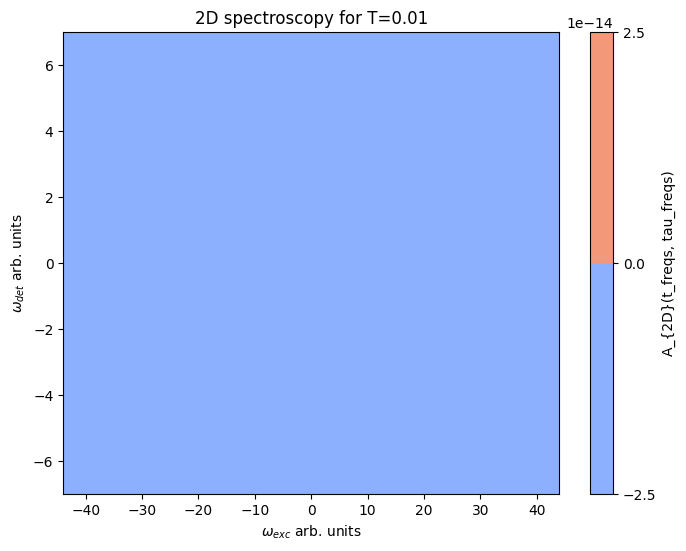

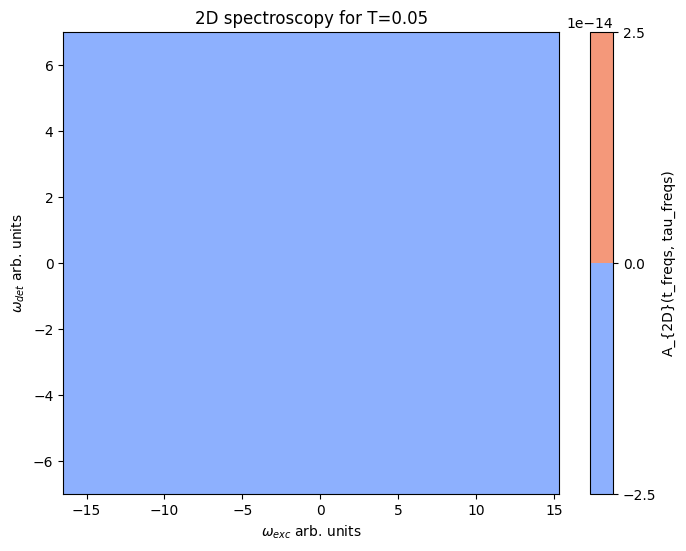

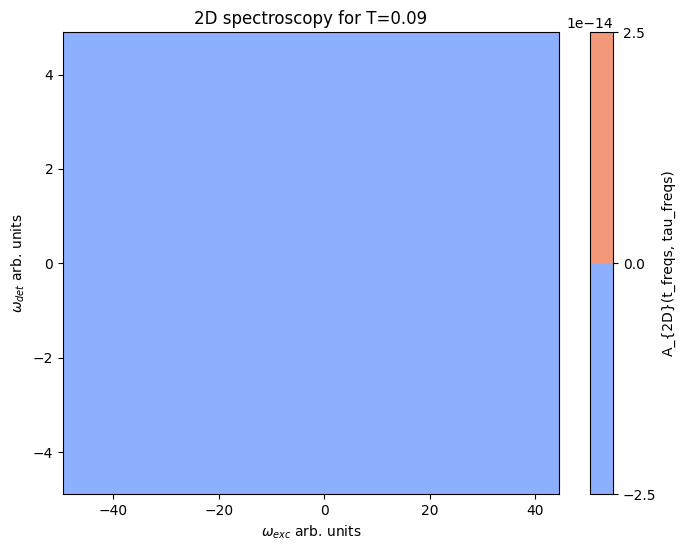

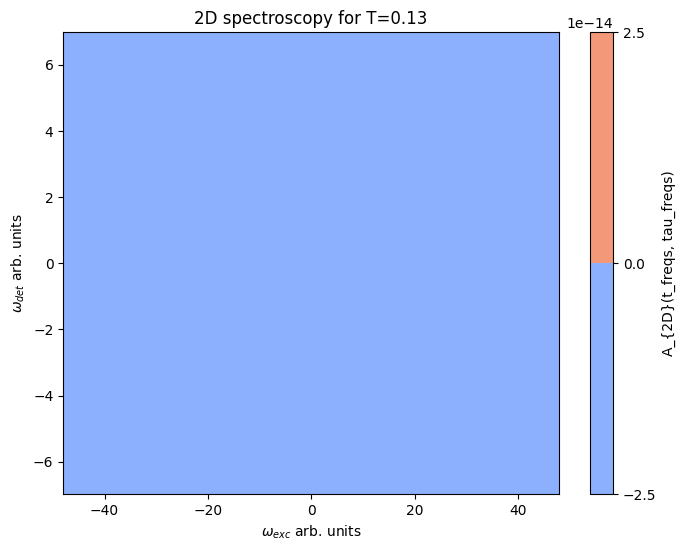

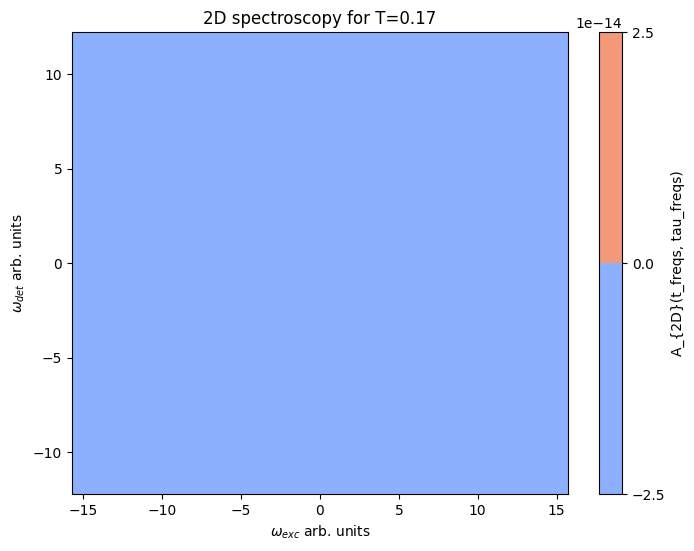

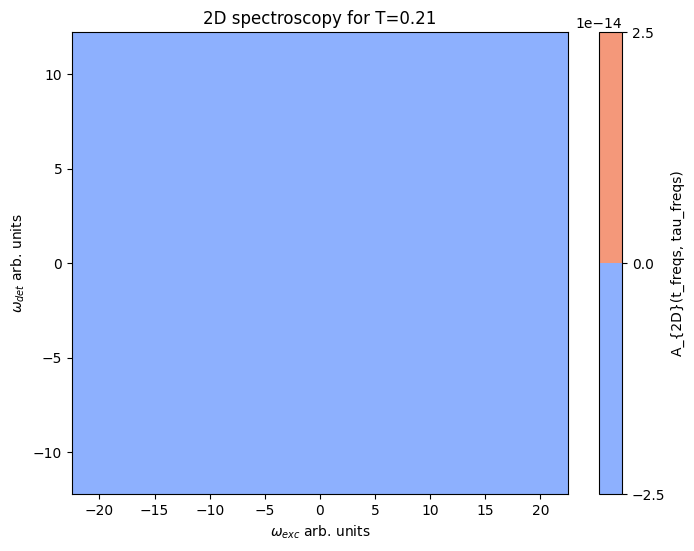

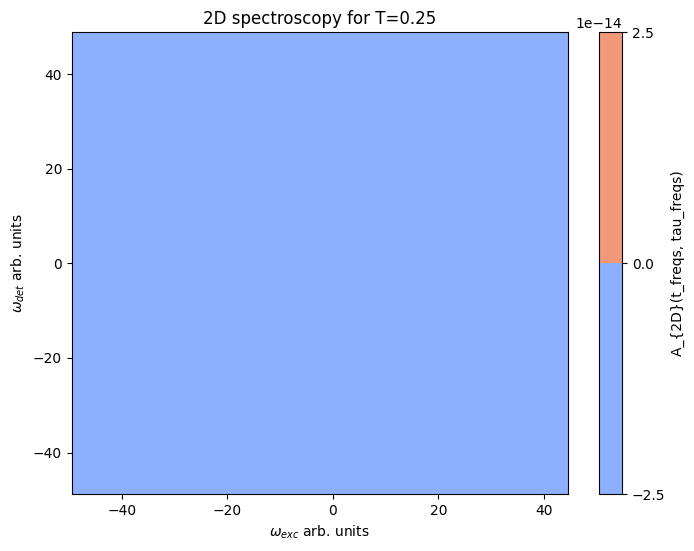

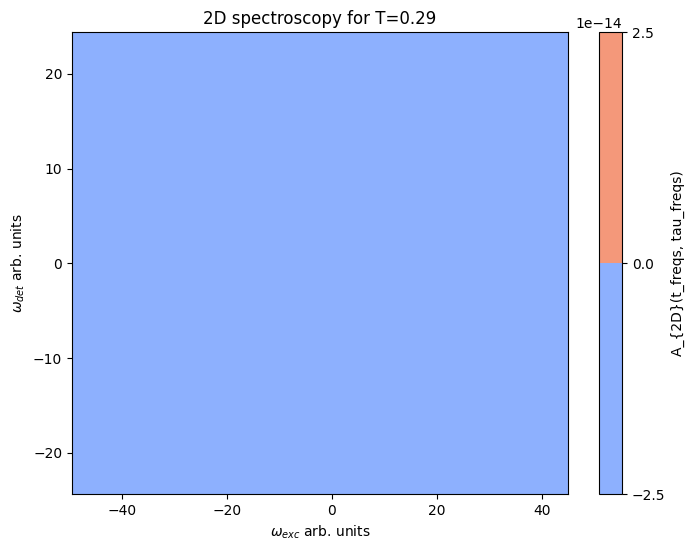

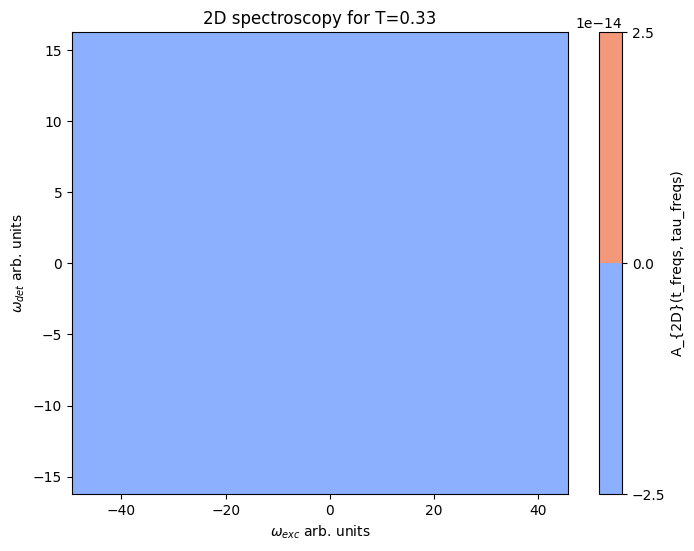

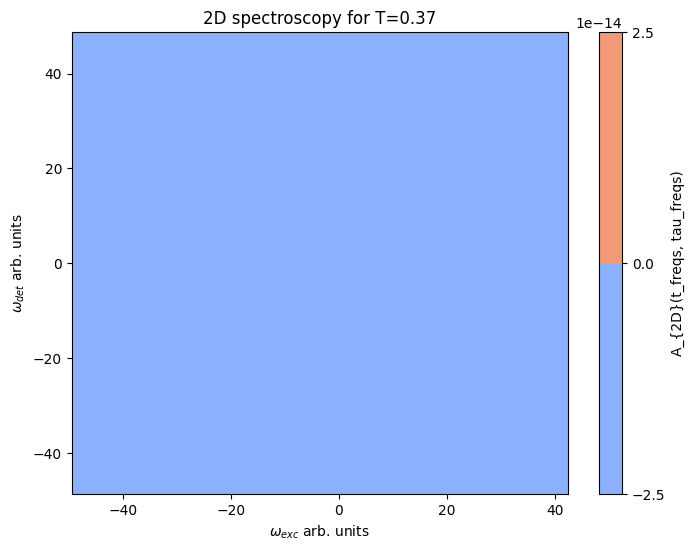

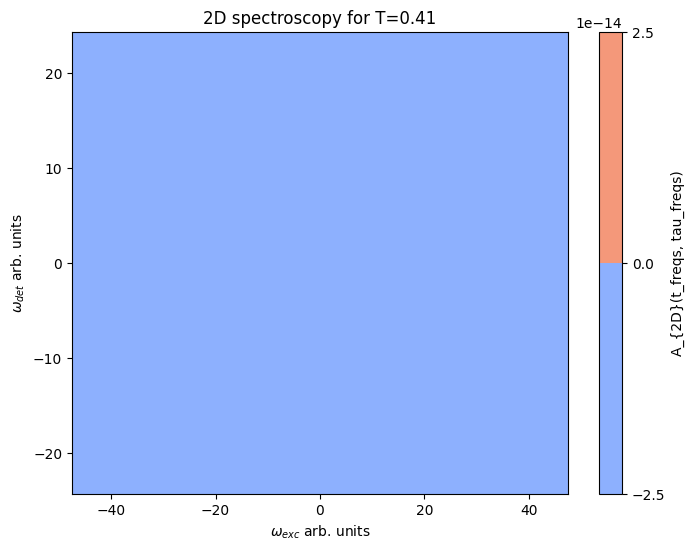

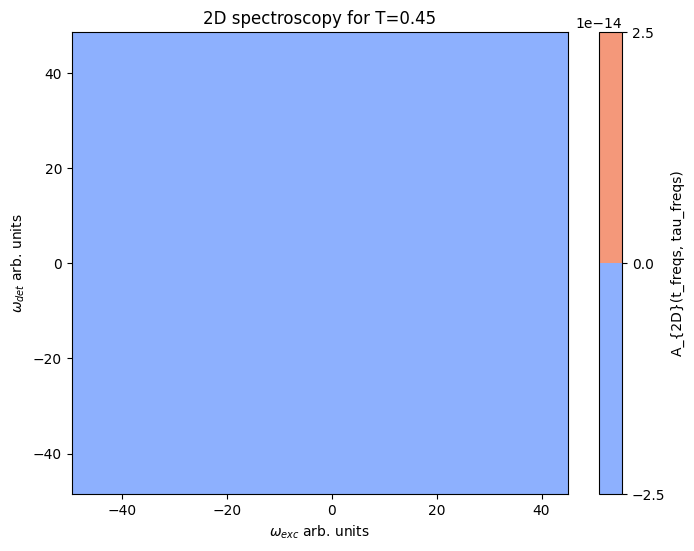

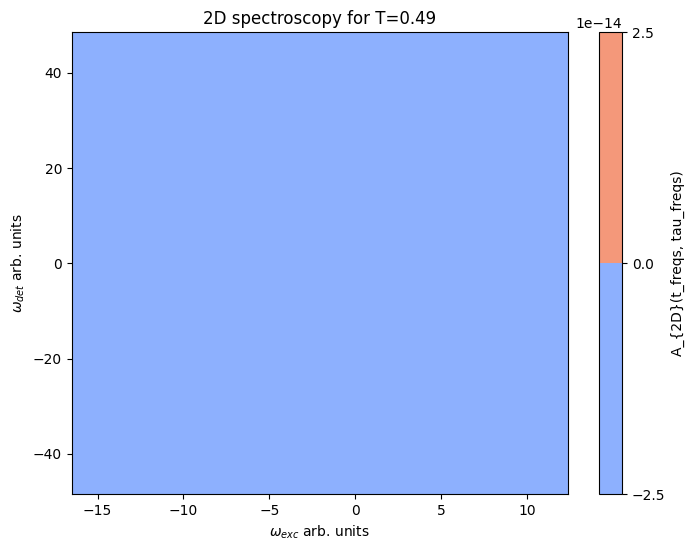

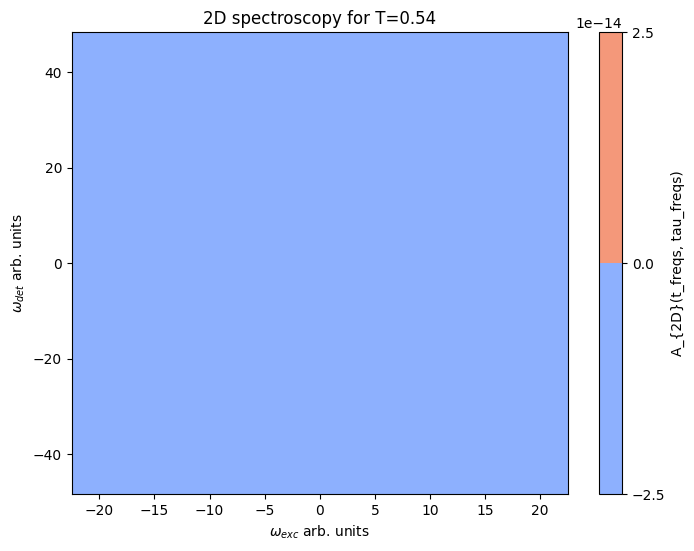

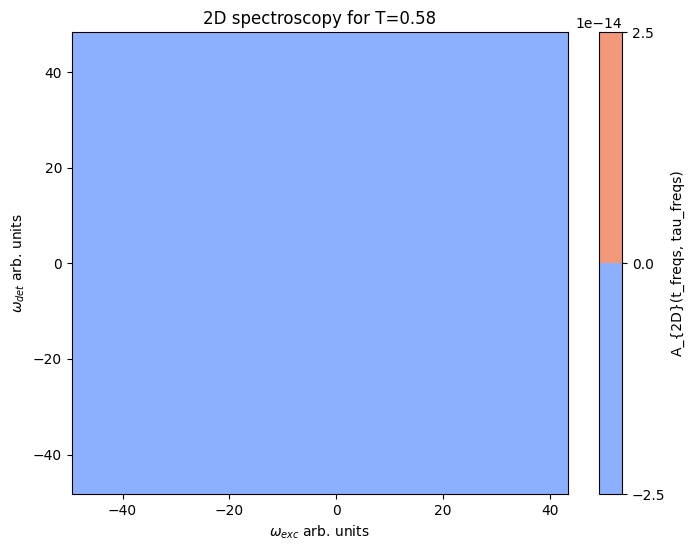

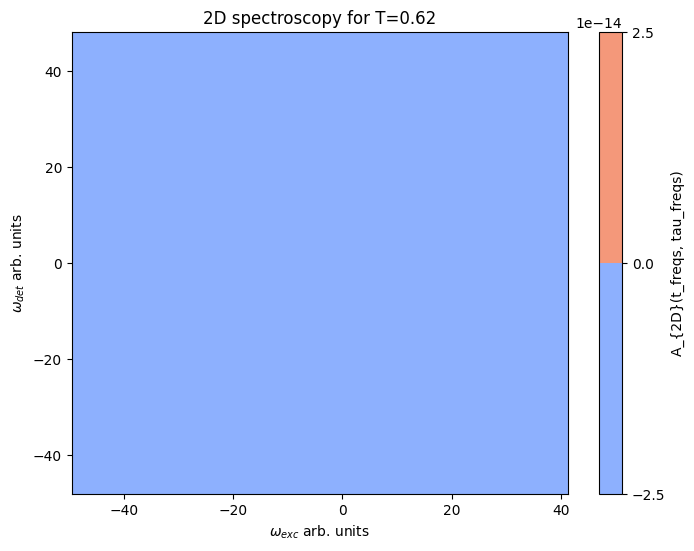

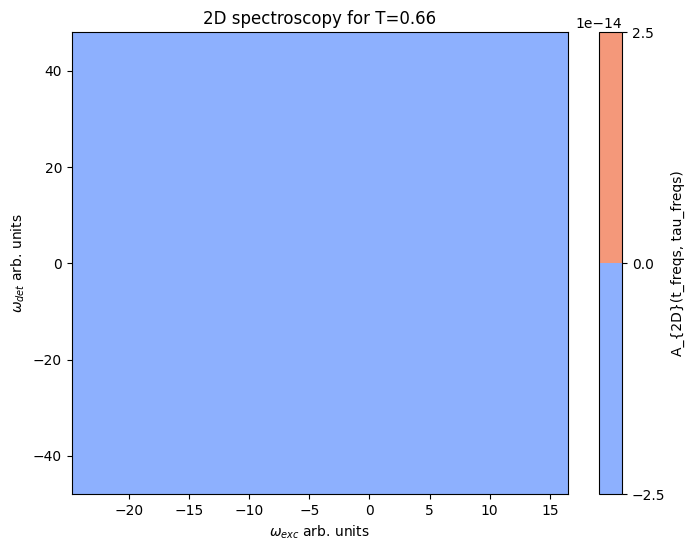

/tmp/ipykernel_129342/3409731987.py:52: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('$\omega_{exc}$ arb. units')
/tmp/ipykernel_129342/3409731987.py:53: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$\omega_{det}$ arb. units')


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (29, 1)

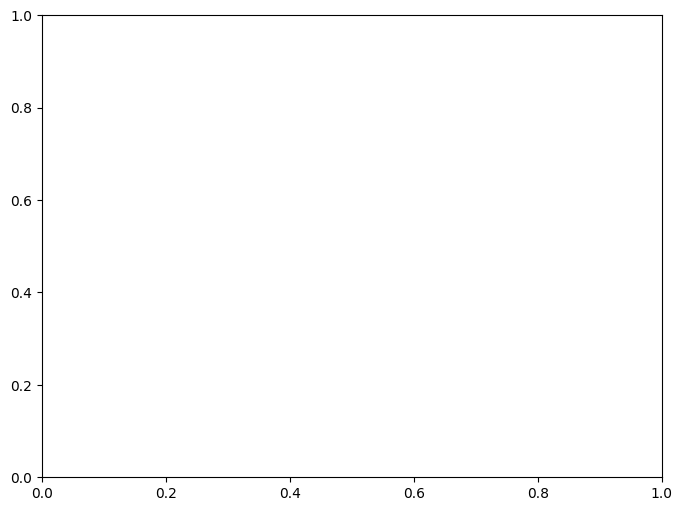

In [18]:
# Dictionary to store FT results
FT_results_dict = {}

# Perform computation of A = -t_freqs * IM(FT_data) for each T
for idx, (T, (values_array, ts, taus)) in enumerate(two_d_array_dict.items()):
    # Only plot every second entry
    if idx % 4 != 0:
        continue

    # Compute the 2D Fast Fourier Transform
    FT_data = np.fft.fft2(values_array)  # Complex Fourier coefficients
    # Shift zero frequency component to the center
    FT_data_shifted = np.fft.fftshift(FT_data)

    # Compute frequency arrays for the t-axis and tau-axis

    # Compute frequency arrays for the t-axis and tau-axis
    if len(ts) > 1:
        t_freqs = np.fft.fftshift(np.fft.fftfreq(len(ts), ts[1] - ts[0]))
    else:
        t_freqs = np.array([0])  # Single point: frequency is 0

    if len(taus) > 1:
        tau_freqs = np.fft.fftshift(np.fft.fftfreq(len(taus), taus[1] - taus[0]))
    else:
        tau_freqs = np.array([0])  # Single point: frequency is 0


    # Fix broadcasting issue by reshaping t_freq
    t_freqs_2D = t_freqs[:, np.newaxis]  # Makes it (47, 1), compatible with (47, 23)

    # Compute A
    A = -t_freqs_2D * np.imag(FT_data_shifted)  # Broadcasts correctly

    # Save the result in FT_results_dict
    FT_results_dict[T] = {
        'A': A,
        't_freqs': t_freqs,
        'tau_freqs': tau_freqs
    }

    # Plot A(t_freqs, tau_freqs)
    plt.figure(figsize=(8, 6))
    plt.contourf(
        tau_freqs,  # x-axis (ω_exc)
        t_freqs,  # y-axis (ω_det)
        A,  # Do NOT transpose A; its shape already matches (y, x)
        cmap='coolwarm'
    )
    plt.colorbar(label='A_{2D}(t_freqs, tau_freqs)')
    plt.title(f'2D spectroscopy for T={T:.2f}')
    plt.xlabel('$\omega_{exc}$ arb. units')
    plt.ylabel('$\omega_{det}$ arb. units')
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2D grid
x_vals = np.linspace(-10, 10, 256)  # X axis
y_vals = np.linspace(-10, 10, 256)  # Y axis
X_vals, Y_vals = np.meshgrid(x_vals, y_vals)  # Create a 2D grid of coordinates

# Choose any 2D function for Y_vals
Y_vals = np.sin(2 * np.pi * 1 * X_vals) * np.sin(2 * np.pi * 1 * Y_vals)  # Example: 2D sine wave
#Y_vals = np.sign(np.sin(2 * np.pi * X_vals)) * np.sign(np.sin(2 * np.pi * Y_vals))

# Step 1: Compute the 2D Fourier Transform using numpy's fft2
FT_vals = np.fft.fft2(Y_vals)

# Step 2: Shift the zero frequency component to the center
FT_vals_shifted = np.fft.fftshift(FT_vals)

# Step 3: Compute the corresponding frequency values for both axes
delta_x = x_vals[1] - x_vals[0]
delta_y = y_vals[1] - y_vals[0]
freq_x = np.fft.fftfreq(len(x_vals), delta_x)  # Frequencies for the X axis
freq_y = np.fft.fftfreq(len(y_vals), delta_y)  # Frequencies for the Y axis
freq_x, freq_y = np.meshgrid(freq_x, freq_y)  # Create a 2D meshgrid for the frequencies

# Step 5: Plot the results (Magnitude of the FT for positive frequencies)
magnitude = np.abs(FT_vals_shifted)

# Plot the magnitude of the Fourier Transform (log scale for better visualization)
plt.figure(figsize=(8, 6))
plt.imshow(np.log(1 + magnitude), extent=(freq_x.min(), freq_x.max(), freq_y.min(), freq_y.max()))
plt.title('Magnitude of 2D Fourier Transform (Positive Frequencies)')
plt.xlabel('Frequency in X (Hz)')
plt.ylabel('Frequency in Y (Hz)')
plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()
